# Build CpG Detector

Here we have a simple problem, given a DNA sequence (of N, A, C, G, T), count the number of CpGs in the sequence (consecutive CGs).

We have defined a few helper functions / parameters for performing this task.

We need you to build a LSTM model and train it to complish this task in PyTorch.

A good solution will be a model that can be trained, with high confidence in correctness.

In [1]:
from typing import Sequence
from functools import partial
import random
import torch
import numpy as np
import random

In [2]:
# DO NOT CHANGE HERE
def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(13)

# Use this for getting x label
def rand_sequence(n_seqs: int, seq_len: int=128) -> Sequence[int]:
    for i in range(n_seqs):
        yield [random.randint(0, 4) for _ in range(seq_len)]

# Use this for getting y label
def count_cpgs(seq: str) -> int:
    cgs = 0
    for i in range(0, len(seq) - 1):
        dimer = seq[i:i+2]
        # note that seq is a string, not a list
        if dimer == "CG":
            cgs += 1
    return cgs

# Alphabet helpers
alphabet = 'NACGT'
dna2int = { a: i for a, i in zip(alphabet, range(5))}
int2dna = { i: a for a, i in zip(alphabet, range(5))}

intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

In [3]:
# we prepared two datasets for training and evaluation
# training data scale we set to 2048
# we test on 512

def prepare_data(num_samples=100):
    X_dna_seqs_train = list(rand_sequence(num_samples))
    temp = [''.join(list(intseq_to_dnaseq(seq))) for seq in X_dna_seqs_train]
    y_dna_seqs = [count_cpgs(seq) for seq in temp]
    return X_dna_seqs_train, y_dna_seqs

train_x, train_y = prepare_data(2048)
test_x, test_y = prepare_data(512)

In [4]:
# some config
LSTM_HIDDEN = 256  # Increase the hidden layer size
LSTM_LAYER = 1
batch_size = 64  # Increase the batch size for better generalization
learning_rate = 0.001  # Adjust the learning rate

#LSTM_HIDDEN = 128  # Increase the hidden layer size
#LSTM_LAYER = 1
#batch_size = 64  # Increase the batch size for better generalization
#learning_rate = 0.0005  # Adjust the learning rate
#20 epochs ***Highest Loss***

In [5]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = [torch.LongTensor(d) for d in data]
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

# Create DataLoader
train_data_loader = DataLoader(MyDataset(train_x, train_y), batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(MyDataset(test_x, test_y), batch_size=batch_size)



In [6]:
# Model
class CpGPredictor(torch.nn.Module):
    def __init__(self):
        super(CpGPredictor, self).__init__()
        self.embedding = torch.nn.Embedding(5, 32)
        self.lstm = torch.nn.LSTM(32, LSTM_HIDDEN, LSTM_LAYER, batch_first=True, dropout=0.2)  # Add dropout
        self.classifier = torch.nn.Linear(LSTM_HIDDEN, 1)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        logits = self.classifier(lstm_out[:, -1, :])
        return logits

In [7]:
# init model / loss function / optimizer etc.
model = CpGPredictor()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [8]:
# Training Loop *Best Results*
epoch_num = 35 # Increase the number of epochs
t_loss = 0.0
model.train()
for epoch in range(epoch_num):
    for batch_x, batch_y in train_data_loader:
        batch_y = batch_y.view(-1, 1)  # Reshape labels
        optimizer.zero_grad()
        output = model(batch_x)
        loss = loss_fn(output, batch_y)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {t_loss}')
    t_loss = 0.0


Epoch 1, Loss: 295.600816488266
Epoch 2, Loss: 134.79753398895264
Epoch 3, Loss: 133.50246739387512
Epoch 4, Loss: 135.07234644889832
Epoch 5, Loss: 134.30378675460815
Epoch 6, Loss: 134.7870762348175
Epoch 7, Loss: 134.84644722938538
Epoch 8, Loss: 133.31955742835999
Epoch 9, Loss: 133.3934292793274
Epoch 10, Loss: 133.13241958618164
Epoch 11, Loss: 133.78104424476624
Epoch 12, Loss: 133.18542623519897
Epoch 13, Loss: 133.6546494960785
Epoch 14, Loss: 132.52719688415527
Epoch 15, Loss: 132.43425035476685
Epoch 16, Loss: 133.05110788345337
Epoch 17, Loss: 134.5728940963745
Epoch 18, Loss: 133.51310896873474
Epoch 19, Loss: 130.07048058509827
Epoch 20, Loss: 127.46910500526428
Epoch 21, Loss: 102.84210419654846
Epoch 22, Loss: 50.81541472673416
Epoch 23, Loss: 24.85306540131569
Epoch 24, Loss: 13.689798176288605
Epoch 25, Loss: 8.117479726672173
Epoch 26, Loss: 6.702491544187069
Epoch 27, Loss: 5.307144723832607
Epoch 28, Loss: 3.2015579640865326
Epoch 29, Loss: 2.2362004220485687
Epoch

In [9]:
from sklearn.metrics import mean_squared_error, r2_score

# Inference and Evaluation Loop
model.eval()

res_gs = []
res_pred = []
mse_loss = 0.0

with torch.no_grad():
    for batch_x, batch_y in test_data_loader:
        batch_y = batch_y.view(-1, 1)  # Reshape labels
        output = model(batch_x)

        # Accumulate MSE loss for later averaging
        mse_loss += loss_fn(output, batch_y).item()

        res_gs.extend(batch_y.cpu().numpy().flatten().tolist())
        res_pred.extend(output.cpu().numpy().flatten().tolist())

# Calculate the average MSE over all test batches
avg_mse_loss = mse_loss / len(test_data_loader)

# Calculate additional statistical metrics
r2 = r2_score(res_gs, res_pred)

avg_mse_loss, r2


(0.02131702471524477, 0.9948718024741298)

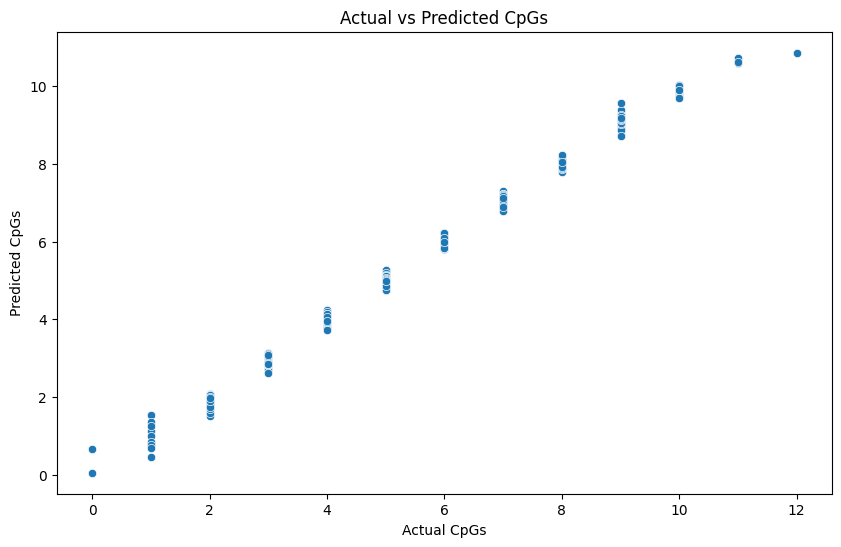

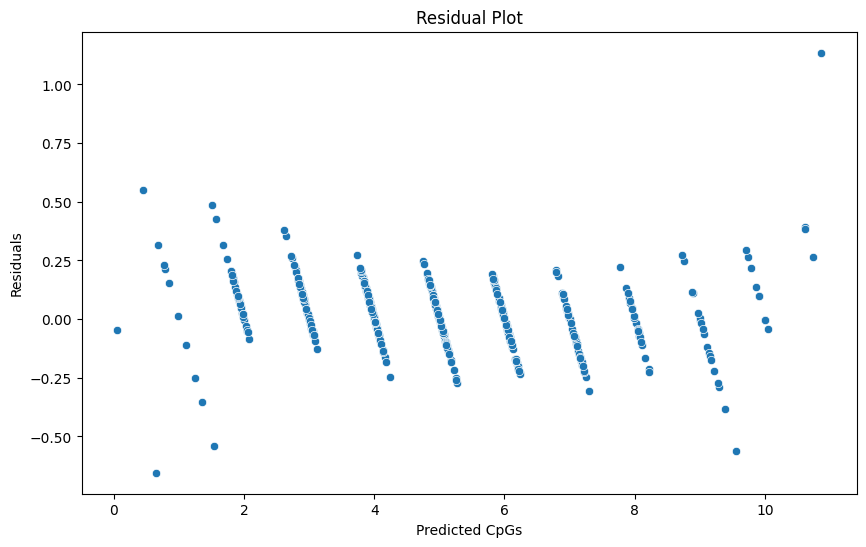

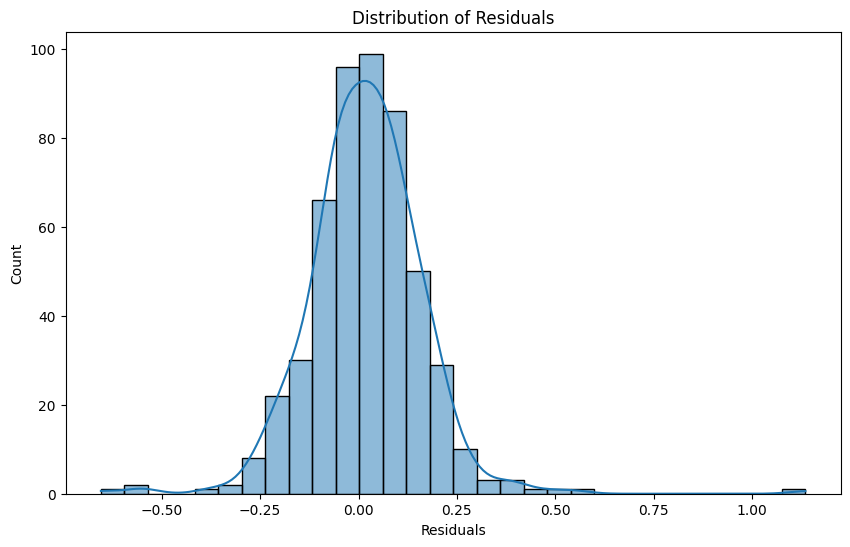

In [10]:
# TODO complete evaluation of the model
import matplotlib.pyplot as plt
import seaborn as sns

# Data for plotting
actual = res_gs
predicted = res_pred

# Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=actual, y=predicted)
plt.xlabel('Actual CpGs')
plt.ylabel('Predicted CpGs')
plt.title('Actual vs Predicted CpGs')
plt.show()

# Residual Plot
plt.figure(figsize=(10, 6))
residuals = [act - pred for act, pred in zip(actual, predicted)]
sns.scatterplot(x=predicted, y=residuals)
plt.xlabel('Predicted CpGs')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Distribution of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()



In [11]:
# Save the model parameters
torch.save(model.state_dict(), 'cpg.pth')


# Model Demo

In [12]:
!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.8/298.8 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 7.7 MB/

In [13]:
import gradio as gr
import torch
import numpy as np

# Exixting model class
class CpGPredictor(torch.nn.Module):
    def __init__(self):
        super(CpGPredictor, self).__init__()
        self.embedding = torch.nn.Embedding(5, 32)
        self.lstm = torch.nn.LSTM(32, 256, 1, batch_first=True, dropout=0.2)
        self.classifier = torch.nn.Linear(256, 1)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        logits = self.classifier(lstm_out[:, -1, :])
        return logits

# Load model
def load_model():
    model = CpGPredictor()
    model.load_state_dict(torch.load("cpg.pth"))
    model.eval()
    return model

model = load_model()

def predict_cpg(dna_sequence: str):
    # Convert DNA to integer sequence
    alphabet = 'NACGT'
    dna2int = {a: i for a, i in zip(alphabet, range(5))}
    int_seq = [dna2int[base] for base in dna_sequence.upper()]

    # Prepare tensor and run model prediction
    input_tensor = torch.tensor([int_seq], dtype=torch.long)
    with torch.no_grad():
        output = model(input_tensor)

    # Return result
    return f"Predicted CpG count: {output.item():.2f}"

iface = gr.Interface(
    fn=predict_cpg,
    inputs="text",
    outputs="text",
    live=True,
    interpretation=None
)

iface.launch()


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://5a32e7665bee4ea651.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
